In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import os
import requests
import tempfile
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1
from functools import partialmethod
import pymysql

In [2]:
client = bigquery.Client.from_service_account_json('./lwapps-coloring.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./lwapps-coloring.json')
project_id = 'lwapps-coloring'

In [4]:
# Забираем ивенты рекламы с плэйсментом 
sql = '''   
SELECT event_date, event_timestamp, event_name, user_id, platform, param1.value.string_value as placement
FROM `lwapps-coloring.analytics_218793363.events_*`,
unnest(event_params) as param1
where (_TABLE_SUFFIX between '20210401' AND '20210420')  
and event_name in ("ad_interstitial_view", "ad_video_view")
and param1.key = 'placement'
'''
ads = client.query(sql, project=project_id).to_dataframe()
ads = ads[~ads.user_id.isna()]
ads['event_timestamp'] = pd.to_datetime(ads['event_timestamp']/1000, unit='ms')

sql = '''   
SELECT event_date, event_timestamp, event_name, user_id, platform, param2.value.string_value as time_since
FROM `lwapps-coloring.analytics_218793363.events_*`,
unnest(event_params) as param2
where (_TABLE_SUFFIX between '20210401' AND '20210420')  
and event_name = "return_to_app"
and (param2.key = 'timeSince')
'''
come_back = client.query(sql, project=project_id).to_dataframe()
come_back = come_back[~come_back.user_id.isna()]
come_back['event_timestamp'] = pd.to_datetime(come_back['event_timestamp']/1000, unit='ms')

In [11]:
sql = '''
SELECT event_date, event_timestamp, event_name, user_id, platform
FROM `lwapps-coloring.analytics_218793363.events_*`
where (_TABLE_SUFFIX between '20210401' AND '20210420')  
and event_name = "launch"
'''
launch = client.query(sql, project=project_id).to_dataframe()
launch = launch[~launch.user_id.isna()]
launch['event_timestamp'] = pd.to_datetime(launch['event_timestamp']/1000, unit='ms')

In [32]:
tb = pd.concat([ads, come_back, launch])
tb = tb.sort_values(by=['user_id', 'event_timestamp'])
tb.head(10)

# Отфильтровываем ивенты до первого лаунча
first_launch = tb[tb.event_name=='launch'].groupby("user_id").event_timestamp.min().reset_index()

tb = tb.merge(first_launch, how='left', on='user_id')
tb.rename(columns={"event_timestamp_x": "event_timestamp", "event_timestamp_y": "first_launch"}, inplace=True) 
tb = tb[(~tb.first_launch.isna()) & (tb.event_timestamp>=tb.first_launch)]

# Считаем ивенты с первого лаунча
tb = tb.sort_values(by=['user_id', 'event_timestamp'])
tb['event_count'] = tb.groupby("user_id")["event_timestamp"].rank(method="first", ascending=True)

In [33]:
launches = tb[tb.event_name=='launch'][['event_timestamp', 'user_id']]
launches['launch_count'] = launches.groupby("user_id").event_timestamp.rank(method="first", ascending=True)

tb = tb.merge(launches, how='left', on=['event_timestamp', 'user_id'])

# Заполняем пропуски в нумерации лаунчей
tb['launch_count'].fillna(method='pad', inplace=True)


In [34]:
# Ищем время показа первой рекламы в рамках сессии
first_ads = tb[tb.event_name.isin(['ad_interstitial_view', 'ad_video_view'])].groupby(['user_id', 'launch_count']).event_timestamp.min().reset_index()

# Ищем время первого return_to_app в рамках сессии
first_return = tb[tb.event_name.isin(['return_to_app'])].groupby(['user_id', 'launch_count']).event_timestamp.min().reset_index()

first_return.rename(columns={"event_timestamp": "first_return"}, inplace=True)
first_ads.rename(columns={"event_timestamp": "first_ads"}, inplace=True)

tb = tb.merge(first_return, how='left', on=["user_id", "launch_count"])
tb = tb.merge(first_ads, how='left', on=["user_id", "launch_count"])

In [43]:
tb['minutes_diff']= abs((tb['first_ads'] - tb['first_return']).dt.total_seconds()/60.0)

In [46]:
646/60

10.766666666666667

In [55]:
minutes_diff = tb[~tb.minutes_diff.isna()][['user_id', 'launch_count', 'minutes_diff', 'platform']].drop_duplicates()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020059EB1160>]],
      dtype=object)

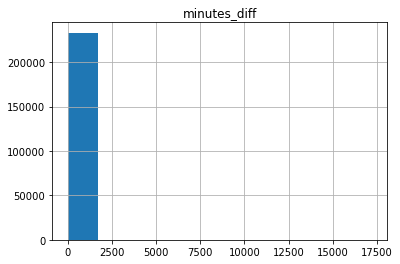

In [51]:
minutes_diff.hist('minutes_diff')

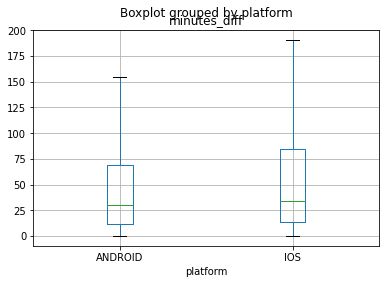

In [56]:
minutes_diff.boxplot('minutes_diff', by = 'platform', sym='')

In [52]:
minutes_diff.describe()

launch_count   minutes_diff
count  233447.000000  233447.000000
mean       18.012658     100.325568
std        22.977443     241.000442
min         1.000000       0.000033
25%         4.000000      12.778700
50%        11.000000      32.214983
75%        23.000000      76.298075
max       695.000000   17219.001017

In [58]:
# Берем длиннее период

# Забираем ивенты рекламы с плэйсментом 
sql = '''   
SELECT event_date, event_timestamp, event_name, user_id, platform, app_info.version, param1.value.string_value as placement
FROM `lwapps-coloring.analytics_218793363.events_*`,
unnest(event_params) as param1
where (_TABLE_SUFFIX between '20210301' AND '20210420')  
and event_name in ("ad_interstitial_view", "ad_video_view")
and param1.key = 'placement'
'''
ads = client.query(sql, project=project_id).to_dataframe()
ads = ads[~ads.user_id.isna()]
ads['event_timestamp'] = pd.to_datetime(ads['event_timestamp']/1000, unit='ms')

sql = '''   
SELECT event_date, event_timestamp, event_name, user_id, platform, app_info.version, param2.value.string_value as time_since
FROM `lwapps-coloring.analytics_218793363.events_*`,
unnest(event_params) as param2
where (_TABLE_SUFFIX between '20210301' AND '20210420')  
and event_name = "return_to_app"
and (param2.key = 'timeSince')
'''
come_back = client.query(sql, project=project_id).to_dataframe()
come_back = come_back[~come_back.user_id.isna()]
come_back['event_timestamp'] = pd.to_datetime(come_back['event_timestamp']/1000, unit='ms')

sql = '''
SELECT event_date, event_timestamp, event_name, user_id, platform, app_info.version
FROM `lwapps-coloring.analytics_218793363.events_*`
where (_TABLE_SUFFIX between '20210301' AND '20210420')  
and event_name = "launch"
'''
launch = client.query(sql, project=project_id).to_dataframe()
launch = launch[~launch.user_id.isna()]
launch['event_timestamp'] = pd.to_datetime(launch['event_timestamp']/1000, unit='ms')

In [59]:
tb = pd.concat([ads, come_back, launch])
tb = tb.sort_values(by=['user_id', 'event_timestamp'])
tb.head(10)

# Отфильтровываем ивенты до первого лаунча
first_launch = tb[tb.event_name=='launch'].groupby("user_id").event_timestamp.min().reset_index()

tb = tb.merge(first_launch, how='left', on='user_id')
tb.rename(columns={"event_timestamp_x": "event_timestamp", "event_timestamp_y": "first_launch"}, inplace=True) 
tb = tb[(~tb.first_launch.isna()) & (tb.event_timestamp>=tb.first_launch)]

# Считаем ивенты с первого лаунча
tb = tb.sort_values(by=['user_id', 'event_timestamp'])
tb['event_count'] = tb.groupby("user_id")["event_timestamp"].rank(method="first", ascending=True)

launches = tb[tb.event_name=='launch'][['event_timestamp', 'user_id']]
launches['launch_count'] = launches.groupby("user_id").event_timestamp.rank(method="first", ascending=True)

tb = tb.merge(launches, how='left', on=['event_timestamp', 'user_id'])

# Заполняем пропуски в нумерации лаунчей
tb['launch_count'].fillna(method='pad', inplace=True)

# Ищем время показа первой рекламы в рамках сессии
first_ads = tb[tb.event_name.isin(['ad_interstitial_view', 'ad_video_view'])].groupby(['user_id', 'launch_count']).event_timestamp.min().reset_index()

# Ищем время первого return_to_app в рамках сессии
first_return = tb[tb.event_name.isin(['return_to_app'])].groupby(['user_id', 'launch_count']).event_timestamp.min().reset_index()

first_return.rename(columns={"event_timestamp": "first_return"}, inplace=True)
first_ads.rename(columns={"event_timestamp": "first_ads"}, inplace=True)

tb = tb.merge(first_return, how='left', on=["user_id", "launch_count"])
tb = tb.merge(first_ads, how='left', on=["user_id", "launch_count"])

tb['minutes_diff']= abs((tb['first_ads'] - tb['first_return']).dt.total_seconds()/60.0)

In [61]:
tb

event_date               event_timestamp            event_name  \
0          20210306 2021-03-06 00:18:45.575011072                launch   
1          20210306 2021-03-06 00:19:07.533001984  ad_interstitial_view   
2          20210328 2021-03-28 00:41:42.056011008                launch   
3          20210328 2021-03-28 00:45:07.607001856         return_to_app   
4          20210328 2021-03-28 00:45:07.975003904  ad_interstitial_view   
...             ...                           ...                   ...   
12309765   20210406 2021-04-06 01:57:01.460007168  ad_interstitial_view   
12309766   20210406 2021-04-06 02:14:15.426006016  ad_interstitial_view   
12309767   20210406 2021-04-06 02:23:31.459006208  ad_interstitial_view   
12309768   20210406 2021-04-06 02:25:27.119001856  ad_interstitial_view   
12309769   20210406 2021-04-06 02:44:49.660004864  ad_interstitial_view   

         user_id platform version          placement time_since  \
0         100002      IOS    1.23                NaN        NaN   
1         100002      IOS    1.23  EnterCoreGameplay        NaN   
2         100008      IOS    1.23                NaN        NaN   
3         100008      IOS    1.23                NaN     121872   
4         100008      IOS    1.23        returnToApp        NaN   
...          ...      ...     ...                ...        ...   
12309765   99997      IOS    1.23        returnToApp        NaN   
12309766   99997      IOS    1.23    WinCoreGameplay        NaN   
12309767   99997      IOS    1.23    WinCoreGameplay        NaN   
12309768   99997      IOS    1.23  EnterCoreGameplay        NaN   
12309769   99997      IOS    1.23    WinCoreGameplay        NaN   

                          first_launch  event_count  launch_count  \
0        2021-03-06 00:18:45.575011072          1.0           1.0   
1        2021-03-06 00:18:45.575011072          2.0           1.0   
2        2021-03-28 00:41:42.056011008          1.0           1.0   
3        2021-03-28 00:41:42.056011008          2.0           1.0   
4        2021-03-28 00:41:42.056011008          3.0           1.0   
...                                ...          ...           ...   
12309765 2021-03-01 03:04:07.380009984         10.0           5.0   
12309766 2021-03-01 03:04:07.380009984         11.0           5.0   
12309767 2021-03-01 03:04:07.380009984         12.0           5.0   
12309768 2021-03-01 03:04:07.380009984         13.0           5.0   
12309769 2021-03-01 03:04:07.380009984         14.0           5.0   

                          first_return                     first_ads  \
0                                  NaT 2021-03-06 00:19:07.533001984   
1                                  NaT 2021-03-06 00:19:07.533001984   
2        2021-03-28 00:45:07.607001856 2021-03-28 00:45:07.975003904   
3        2021-03-28 00:45:07.607001856 2021-03-28 00:45:07.975003904   
4        2021-03-28 00:45:07.607001856 2021-03-28 00:45:07.975003904   
...                                ...                           ...   
12309765 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309766 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309767 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309768 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309769 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   

          minutes_diff  
0                  NaN  
1                  NaN  
2             0.006133  
3             0.006133  
4             0.006133  
...                ...  
12309765     11.381716  
12309766     11.381716  
12309767     11.381716  
12309768     11.381716  
12309769     11.381716  

[12309770 rows x 14 columns]

In [64]:
minutes_diff = tb[~tb.minutes_diff.isna()][['user_id', 'launch_count', 'minutes_diff', 'platform', "version"]].drop_duplicates()

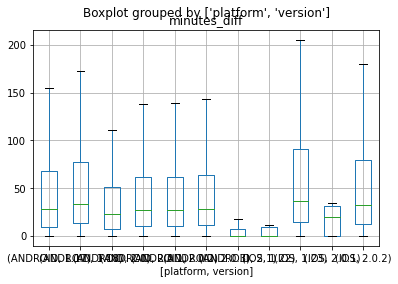

In [65]:
minutes_diff.boxplot('minutes_diff', by = ['platform', 'version'], sym='')

In [84]:
minutes_diff.groupby(['platform', 'version']).minutes_diff.median().reset_index()

platform version  minutes_diff
0   ANDROID    1.17     28.558108
1   ANDROID    1.18     33.715533
2   ANDROID     2.0     22.869167
3   ANDROID   2.0.1     26.738525
4   ANDROID   2.0.2     27.184658
5   ANDROID   2.0.3     28.277783
6   ANDROID     2.1      0.437417
7       IOS    1.22      0.261692
8       IOS    1.23     36.825450
9       IOS   2.0.1     19.975350
10      IOS   2.0.2     32.735400

In [87]:
tb

event_date               event_timestamp            event_name  \
0          20210306 2021-03-06 00:18:45.575011072                launch   
1          20210306 2021-03-06 00:19:07.533001984  ad_interstitial_view   
2          20210328 2021-03-28 00:41:42.056011008                launch   
3          20210328 2021-03-28 00:45:07.607001856         return_to_app   
4          20210328 2021-03-28 00:45:07.975003904  ad_interstitial_view   
...             ...                           ...                   ...   
12309765   20210406 2021-04-06 01:57:01.460007168  ad_interstitial_view   
12309766   20210406 2021-04-06 02:14:15.426006016  ad_interstitial_view   
12309767   20210406 2021-04-06 02:23:31.459006208  ad_interstitial_view   
12309768   20210406 2021-04-06 02:25:27.119001856  ad_interstitial_view   
12309769   20210406 2021-04-06 02:44:49.660004864  ad_interstitial_view   

         user_id platform version          placement time_since  \
0         100002      IOS    1.23                NaN        NaN   
1         100002      IOS    1.23  EnterCoreGameplay        NaN   
2         100008      IOS    1.23                NaN        NaN   
3         100008      IOS    1.23                NaN     121872   
4         100008      IOS    1.23        returnToApp        NaN   
...          ...      ...     ...                ...        ...   
12309765   99997      IOS    1.23        returnToApp        NaN   
12309766   99997      IOS    1.23    WinCoreGameplay        NaN   
12309767   99997      IOS    1.23    WinCoreGameplay        NaN   
12309768   99997      IOS    1.23  EnterCoreGameplay        NaN   
12309769   99997      IOS    1.23    WinCoreGameplay        NaN   

                          first_launch  event_count  launch_count  \
0        2021-03-06 00:18:45.575011072          1.0           1.0   
1        2021-03-06 00:18:45.575011072          2.0           1.0   
2        2021-03-28 00:41:42.056011008          1.0           1.0   
3        2021-03-28 00:41:42.056011008          2.0           1.0   
4        2021-03-28 00:41:42.056011008          3.0           1.0   
...                                ...          ...           ...   
12309765 2021-03-01 03:04:07.380009984         10.0           5.0   
12309766 2021-03-01 03:04:07.380009984         11.0           5.0   
12309767 2021-03-01 03:04:07.380009984         12.0           5.0   
12309768 2021-03-01 03:04:07.380009984         13.0           5.0   
12309769 2021-03-01 03:04:07.380009984         14.0           5.0   

                          first_return                     first_ads  \
0                                  NaT 2021-03-06 00:19:07.533001984   
1                                  NaT 2021-03-06 00:19:07.533001984   
2        2021-03-28 00:45:07.607001856 2021-03-28 00:45:07.975003904   
3        2021-03-28 00:45:07.607001856 2021-03-28 00:45:07.975003904   
4        2021-03-28 00:45:07.607001856 2021-03-28 00:45:07.975003904   
...                                ...                           ...   
12309765 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309766 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309767 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309768 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309769 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   

          minutes_diff  
0                  NaN  
1                  NaN  
2             0.006133  
3             0.006133  
4             0.006133  
...                ...  
12309765     11.381716  
12309766     11.381716  
12309767     11.381716  
12309768     11.381716  
12309769     11.381716  

[12309770 rows x 14 columns]

In [85]:
minutes_diff[['platform', 'version', "user_id", 'launch_count']].drop_duplicates()

platform version user_id  launch_count
2             IOS    1.23  100008           1.0
19            IOS    1.23  100026           5.0
37            IOS    1.23  100026          13.0
47            IOS    1.23  100026          16.0
95            IOS    1.23  100028           2.0
...           ...     ...     ...           ...
12309630      IOS    1.23   99994         114.0
12309648      IOS    1.23   99994         121.0
12309680      IOS    1.23   99994         128.0
12309731      IOS   2.0.2   99994         149.0
12309762      IOS    1.23   99997           5.0

[601807 rows x 4 columns]

In [69]:
minutes_diff[(minutes_diff.platform == 'ANDROID')&(minutes_diff.version == '2.1')]

user_id  launch_count  minutes_diff platform version
1330456  211824         141.0      7.358633  ANDROID     2.1
2784371     308         169.0      0.008583  ANDROID     2.1
4631008  488853         280.0      0.012266  ANDROID     2.1
4631024  488853         285.0      0.013867  ANDROID     2.1
4631036  488853         290.0      3.160300  ANDROID     2.1
4631045  488853         293.0      7.091567  ANDROID     2.1
4631055  488853         295.0      5.800767  ANDROID     2.1
4631060  488853         297.0     18.530367  ANDROID     2.1
4631081  488853         304.0     11.596484  ANDROID     2.1
4631091  488853         309.0      3.181600  ANDROID     2.1
4631099  488853         311.0      0.015550  ANDROID     2.1
4631126  488853         323.0      0.004000  ANDROID     2.1
4787381  505679          96.0      0.003067  ANDROID     2.1
4787395  505679         103.0      0.013733  ANDROID     2.1
4787408  505679         108.0     22.345966  ANDROID     2.1
4787423  505679         115.0     31.702283  ANDROID     2.1
4787440  505679         123.0      0.363750  ANDROID     2.1
4787447  505679         127.0      0.825233  ANDROID     2.1
5716357  591500          26.0      0.177584  ANDROID     2.1
5716378  591500          35.0     53.723217  ANDROID     2.1
5716383  591500          36.0      0.015333  ANDROID     2.1
6026677  614090         102.0      0.483217  ANDROID     2.1
6026680  614090         103.0      0.018433  ANDROID     2.1
7088682  673532         319.0      0.584050  ANDROID     2.1
7091887  673700         233.0      0.080967  ANDROID     2.1
7091916  673700         258.0      0.268984  ANDROID     2.1
7091927  673700         267.0      3.281984  ANDROID     2.1
7091936  673700         271.0      0.391617  ANDROID     2.1
7091964  673700         284.0      0.245500  ANDROID     2.1
7091970  673700         287.0      0.122017  ANDROID     2.1
7437730  692458          78.0     38.121533  ANDROID     2.1
7437742  692458          81.0      0.207467  ANDROID     2.1
7437745  692458          82.0     17.579300  ANDROID     2.1
7437768  692458          90.0     55.441900  ANDROID     2.1
7437797  692458         106.0      0.228317  ANDROID     2.1
7437865  692458         149.0      7.590333  ANDROID     2.1

In [114]:
sessions_with_return = tb[~tb.first_return.isna()]
sessions_with_return = sessions_with_return[sessions_with_return.placement!='returnToApp']
sessions_with_return['event_shifted'] = sessions_with_return.groupby(['user_id', 'launch_count'])['event_name'].shift(1)
sessions_with_return['event_count'] = tb.groupby(["user_id", 'launch_count'])["event_timestamp"].rank(method="first", ascending=True)
sessions_with_return['max_event_count'] = tb.groupby(["user_id", 'launch_count']).event_count.transform("max")

# Удаляем сессии в которых только два ивента 
sessions_with_return = sessions_with_return[sessions_with_return.max_event_count>2]
sessions_with_return = sessions_with_return[["event_timestamp","event_name", 'event_shifted',"user_id","platform","version", "event_count","launch_count"]]
sessions_with_return['time_shifted'] = sessions_with_return.groupby(['user_id', 'launch_count'])['event_timestamp'].shift(1)


In [134]:
# 918787
previous_ad = sessions_with_return[(sessions_with_return.event_name=="return_to_app")&(sessions_with_return.event_shifted.isin(['ad_interstitial_view', 'ad_video_view']))]
sessions_with_return['event_shifted_2'] = sessions_with_return.groupby(['user_id', 'launch_count'])['event_name'].shift(2)
sessions_with_return['time_shifted_2'] = sessions_with_return.groupby(['user_id', 'launch_count'])['event_timestamp'].shift(2)

In [135]:
previous_return = sessions_with_return[(sessions_with_return.event_name=="return_to_app") &
                     (sessions_with_return.event_shifted == 'return_to_app') &
                     (sessions_with_return.event_shifted_2.isin(['ad_interstitial_view', 'ad_video_view']))]


In [139]:
previous_ad['minutes_diff'] = abs((previous_ad['event_timestamp'] - previous_ad['time_shifted']).dt.total_seconds()/60.0)
previous_return['minutes_diff'] = abs((previous_return['event_timestamp'] - previous_return['time_shifted_2']).dt.total_seconds()/60.0)

previous_event = pd.concat([previous_ad[["user_id", "platform", "version", 'launch_count', 'minutes_diff']], previous_return[["user_id", "platform", "version", 'launch_count', 'minutes_diff']]])

<ipython-input-139-6251f274c52d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_ad['minutes_diff'] = abs((previous_ad['event_timestamp'] - previous_ad['time_shifted']).dt.total_seconds()/60.0)
<ipython-input-139-6251f274c52d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_return['minutes_diff'] = abs((previous_return['event_timestamp'] - previous_return['time_shifted_2']).dt.total_seconds()/60.0)


In [141]:
previous_event[previous_event.version != '2.1'].groupby(['platform', 'version']).minutes_diff.median().reset_index()

platform version  minutes_diff
0  ANDROID    1.17     19.361083
1  ANDROID    1.18     19.465450
2  ANDROID     2.0     16.353675
3  ANDROID   2.0.1     17.176550
4  ANDROID   2.0.2     17.304250
5  ANDROID   2.0.3     17.459391
6      IOS    1.23     32.758742
7      IOS   2.0.1     42.876092
8      IOS   2.0.2     29.972658

In [120]:
# sessions_with_return[(sessions_with_return.event_name=="return_to_app")&(sessions_with_return.event_shifted.isin(['ad_interstitial_view', 'return_to_app', 'ad_video_view']))]

sessions_with_return[sessions_with_return.event_name=="return_to_app"].event_shifted.unique()
# previous_ad


array(['launch', 'ad_interstitial_view', 'return_to_app', 'ad_video_view'],
      dtype=object)

In [97]:
sessions_with_return[sessions_with_return.placement!='returnToApp']

event_date               event_timestamp            event_name  \
2          20210328 2021-03-28 00:41:42.056011008                launch   
3          20210328 2021-03-28 00:45:07.607001856         return_to_app   
19         20210310 2021-03-10 02:09:34.007010048                launch   
20         20210310 2021-03-10 02:48:56.150001920         return_to_app   
22         20210310 2021-03-10 02:50:04.160999936  ad_interstitial_view   
...             ...                           ...                   ...   
12309764   20210406 2021-04-06 01:57:00.510002944         return_to_app   
12309766   20210406 2021-04-06 02:14:15.426006016  ad_interstitial_view   
12309767   20210406 2021-04-06 02:23:31.459006208  ad_interstitial_view   
12309768   20210406 2021-04-06 02:25:27.119001856  ad_interstitial_view   
12309769   20210406 2021-04-06 02:44:49.660004864  ad_interstitial_view   

         user_id platform version          placement time_since  \
2         100008      IOS    1.23                NaN        NaN   
3         100008      IOS    1.23                NaN     121872   
19        100026      IOS    1.23                NaN        NaN   
20        100026      IOS    1.23                NaN    2317467   
22        100026      IOS    1.23  EnterCoreGameplay        NaN   
...          ...      ...     ...                ...        ...   
12309764   99997      IOS    1.23                NaN     306166   
12309766   99997      IOS    1.23    WinCoreGameplay        NaN   
12309767   99997      IOS    1.23    WinCoreGameplay        NaN   
12309768   99997      IOS    1.23  EnterCoreGameplay        NaN   
12309769   99997      IOS    1.23    WinCoreGameplay        NaN   

                          first_launch  event_count  launch_count  \
2        2021-03-28 00:41:42.056011008          1.0           1.0   
3        2021-03-28 00:41:42.056011008          2.0           1.0   
19       2021-03-02 02:25:32.042010112         15.0           5.0   
20       2021-03-02 02:25:32.042010112         16.0           5.0   
22       2021-03-02 02:25:32.042010112         18.0           5.0   
...                                ...          ...           ...   
12309764 2021-03-01 03:04:07.380009984          9.0           5.0   
12309766 2021-03-01 03:04:07.380009984         11.0           5.0   
12309767 2021-03-01 03:04:07.380009984         12.0           5.0   
12309768 2021-03-01 03:04:07.380009984         13.0           5.0   
12309769 2021-03-01 03:04:07.380009984         14.0           5.0   

                          first_return                     first_ads  \
2        2021-03-28 00:45:07.607001856 2021-03-28 00:45:07.975003904   
3        2021-03-28 00:45:07.607001856 2021-03-28 00:45:07.975003904   
19       2021-03-10 02:48:56.150001920 2021-03-10 02:48:57.234006016   
20       2021-03-10 02:48:56.150001920 2021-03-10 02:48:57.234006016   
22       2021-03-10 02:48:56.150001920 2021-03-10 02:48:57.234006016   
...                                ...                           ...   
12309764 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309766 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309767 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309768 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   
12309769 2021-04-06 01:57:00.510002944 2021-04-06 01:45:37.607013888   

          minutes_diff  
2             0.006133  
3             0.006133  
19            0.018067  
20            0.018067  
22            0.018067  
...                ...  
12309764     11.381716  
12309766     11.381716  
12309767     11.381716  
12309768     11.381716  
12309769     11.381716  

[5079125 rows x 14 columns]

event_timestamp            event_name  \
2        2021-03-28 00:41:42.056011008                launch   
3        2021-03-28 00:45:07.607001856         return_to_app   
19       2021-03-10 02:09:34.007010048                launch   
20       2021-03-10 02:48:56.150001920         return_to_app   
22       2021-03-10 02:50:04.160999936  ad_interstitial_view   
...                                ...                   ...   
12309764 2021-04-06 01:57:00.510002944         return_to_app   
12309766 2021-04-06 02:14:15.426006016  ad_interstitial_view   
12309767 2021-04-06 02:23:31.459006208  ad_interstitial_view   
12309768 2021-04-06 02:25:27.119001856  ad_interstitial_view   
12309769 2021-04-06 02:44:49.660004864  ad_interstitial_view   

                 event_shifted user_id platform version  event_count  \
2                          NaN  100008      IOS    1.23          1.0   
3                       launch  100008      IOS    1.23          2.0   
19                         NaN  100026      IOS    1.23          1.0   
20                      launch  100026      IOS    1.23          2.0   
22               return_to_app  100026      IOS    1.23          4.0   
...                        ...     ...      ...     ...          ...   
12309764  ad_interstitial_view   99997      IOS    1.23          3.0   
12309766         return_to_app   99997      IOS    1.23          5.0   
12309767  ad_interstitial_view   99997      IOS    1.23          6.0   
12309768  ad_interstitial_view   99997      IOS    1.23          7.0   
12309769  ad_interstitial_view   99997      IOS    1.23          8.0   

          launch_count  
2                  1.0  
3                  1.0  
19                 5.0  
20                 5.0  
22                 5.0  
...                ...  
12309764           5.0  
12309766           5.0  
12309767           5.0  
12309768           5.0  
12309769           5.0  

[5077661 rows x 8 columns]